In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
import nltk
from wordcloud import WordCloud
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.decomposition import LatentDirichletAllocation

In [3]:
# read in songs and replace unwanted characters (new line)
df = pd.read_csv('df_eng_songs.csv', header=0, index_col=0)
df.head()

,Tytuł,Tekst,Eng
0,Abba Ojcze,Ty wyzwoliłeś nas Panie z kajdan i samych sie...,"You delivered us from chains and ourselves, an..."
1,Alleluja (Niech zabrzmi Panu),"Alleluja, Alleluja, Alleluja, Alleluja. Nie...","Alleluia, Alleluia, Alleluia, Alleluia. Let th..."
2,"Alleluja, Alleluja, Amen Amen, Alleluja","Alleluja, Alleluja, Amen, Amen, Alleluja. ...","Alleluia, Alleluia, Amen, Amen, Alleluia. Let ..."
3,"Blisko, blisko, blisko jesteś","Blisko, blisko, blisko Jesteś Panie mój Blisk...","Close, close, close You are my Lord, Close to ..."
4,Bo góry mogą ustąpić,Bo góry mogą ustąpić i pagórki się zachwiać. ...,Because the mountains can give way and the hil...


In [13]:
df['Eng'][:10]

0    You delivered us from chains and ourselves, an...
1    Alleluia, Alleluia, Alleluia, Alleluia. Let th...
2    Alleluia, Alleluia, Amen, Amen, Alleluia. Let ...
3    Close, close, close You are my Lord, Close to ...
4    Because the mountains can give way and the hil...
5    For how death is powerful Love and jealousy ar...
6    God, your grace is upon us, your love is comin...
7    She was as quiet and beautiful as spring, she ...
8    God our Lord is good all the time. So, worship...
9    God loved the world so much that he gave his o...
Name: Eng, dtype: object

In [22]:
# components for features reduction
n_components = 4

# number of clusters we want
n_clusters = 5

# covert words into TFIDF metrics
tfidf = TfidfVectorizer(stop_words = 'english')
X_text = tfidf.fit_transform(df['Eng'])

# reduce dimensions
svd = TruncatedSVD(n_components=n_components, random_state = 0)
X_2d = svd.fit_transform(X_text)

# fit k-mean clustering
kmeans = KMeans(n_clusters=n_clusters, random_state = 0)

# predict our clusters for each song
X_clustered = kmeans.fit_predict(X_2d)

# display by groups
df_plot = pd.DataFrame(list(X_2d), list(X_clustered))
df_plot = df_plot.reset_index()
df_plot.rename(columns = {'index': 'Cluster'}, inplace = True)
df_plot['Cluster'] = df_plot['Cluster'].astype(int)

print(df_plot.head())
print()
print(df_plot.groupby('Cluster').agg({'Cluster': 'count'}))

   Cluster         0         1         2         3
0        1  0.067208  0.015280  0.029584  0.029936
1        0  0.323755 -0.430070  0.152206  0.458847
2        0  0.279478 -0.327783  0.243472  0.493641
3        1  0.130446  0.038740 -0.080460 -0.086619
4        1  0.139951  0.079932  0.001890 -0.063401

         Cluster
Cluster         
0             13
1             83
2             14
3             56
4             21


KeyError: 4

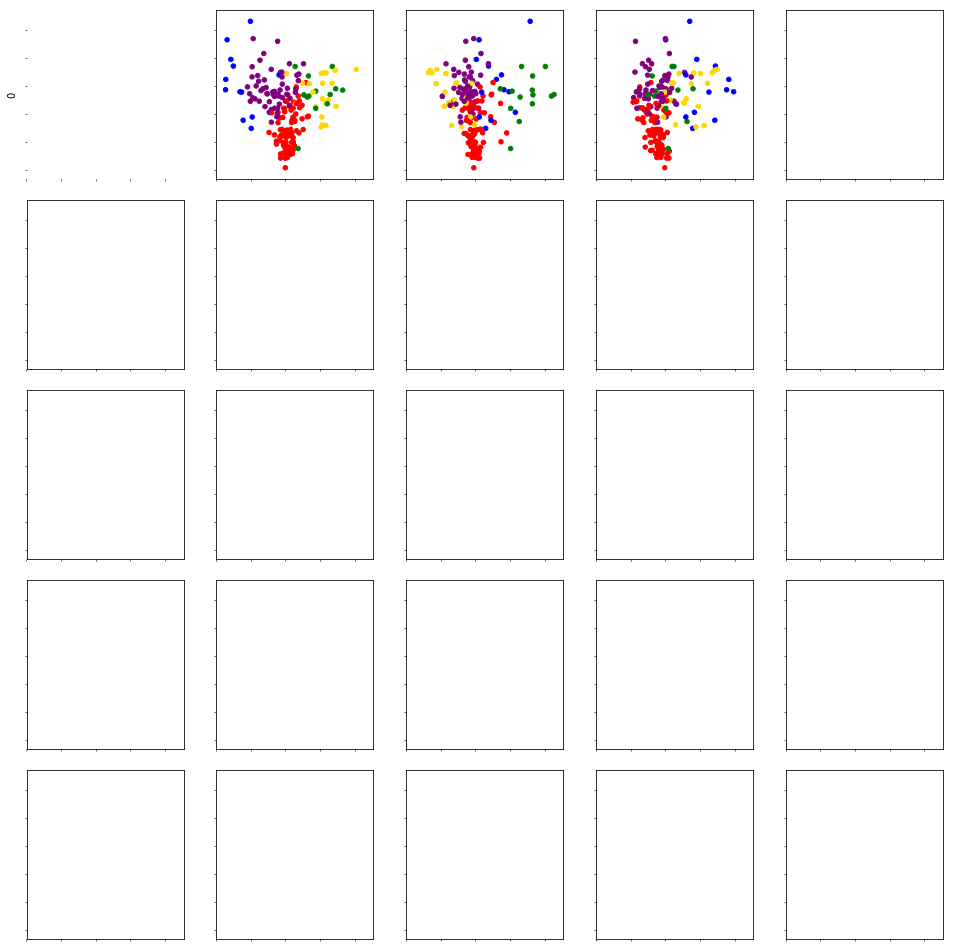

In [23]:
# make a column for color by clusters
col = df_plot['Cluster'].map({0:'b', 1:'r', 2: 'g', 3:'purple', 4:'gold'})

# variable for first n dimensions we want to plot
n = 5

# visualize the clusters by first n dimensions (reduced)
fig, ax = plt.subplots(n, n, sharex=True, sharey=True, figsize=(15,15))
fig.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])

# plot it
k = 0
for i in range(0,n):
    for j in range(0,n):
        if i != j:
            df_plot.plot(kind = 'scatter', x=j, y=i, c=col, ax = ax[i][j], fontsize = 18)
        else:
            ax[i][j].set_xlabel(i)
            ax[i][j].set_ylabel(j)
            ax[i][j].set_frame_on(False)
        ax[i][j].set_xticks([])
        ax[i][j].set_yticks([])
        
plt.suptitle('2D clustering view of the first {} components'.format(n), fontsize = 20)
fig.text(0.5, 0.01, 'Component n', ha='center', fontsize = 18)
fig.text(0.01, 0.5, 'Component n', va='center', rotation='vertical', fontsize = 18)

In [ ]:
# Without Logistic Regression

#df['Cluster'] = df_plot['Cluster']

#def generate_text(cluster):
    #df_s = df[df['Cluster'] == cluster]['text']
    #count = len(df_s)

    
    #tfidf = TfidfVectorizer(stop_words = 'english')
    #X_trans = tfidf.fit_transform(df_s)
    #idf = tfidf.idf_

    #df_result = pd.DataFrame(data = [tfidf.get_feature_names(), list(idf)])
    #df_result = df_result.T
    #df_result.columns = ['words', 'score']
    #df_result = df_result.sort_values(['score'], ascending=False)
    #df_result = df_result[:20]
    #d = df_result.set_index('words')['score'].to_dict()
    #return d


In [ ]:
# Logistic Regression approach

df['Cluster'] = df_plot['Cluster']

# function for finding most significant words for each cluster
def generate_text(cluster):
    
    df_s = df['Eng']
    y = df['Cluster'].map(lambda x: 1 if x == cluster else 0)
    count = len(df_s)
    
    tfidf = TfidfVectorizer(stop_words = 'english')
    X = tfidf.fit_transform(df_s)
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
    clf = LogisticRegression(random_state = 0).fit(X_train, y_train)
    clf_d = DummyClassifier().fit(X_train, y_train)
    acc = clf.score(X_test, y_test)
    acc_d = clf_d.score(X_test, y_test)
    coef = clf.coef_.tolist()[0]
    w = tfidf.get_feature_names()
    coeff_df = pd.DataFrame({'words' : w, 'score' : coef})
    coeff_df = coeff_df.sort_values(['score', 'words'], ascending=[0, 1])
    coeff_df = coeff_df[:30]
    d = coeff_df.set_index('words')['score'].to_dict()
    return d, acc, acc_d

F:\ProgramData\Anaconda3\envs\NLP\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


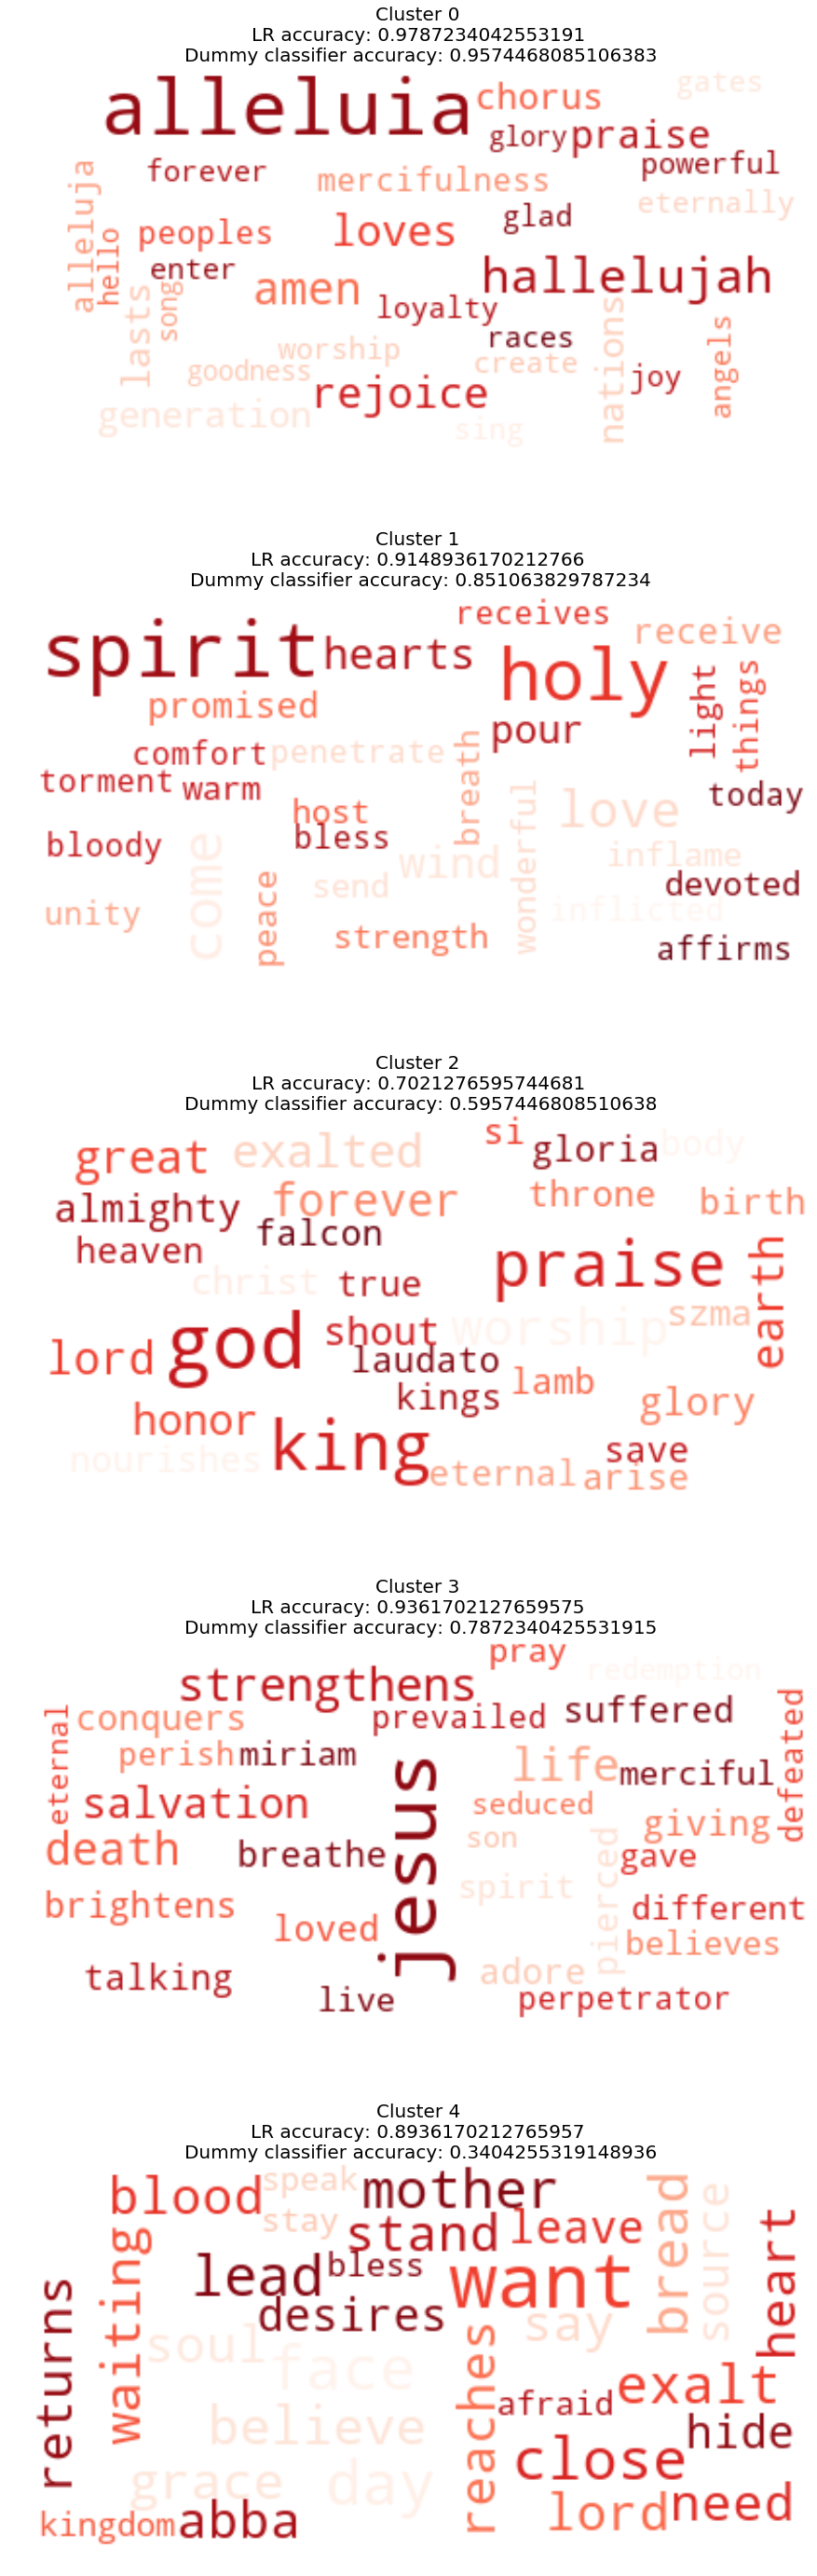

In [18]:
# visualized it by word clouds
fig, ax = plt.subplots(n_clusters, sharex=True, figsize=(15,10*n_clusters))

for i in range(0, n_clusters):
    d, acc, acc_d = generate_text(i)
    wordcloud = WordCloud(max_font_size=40, collocations=False, colormap = 'Reds', background_color = 'white').fit_words(d)
    ax[i].imshow(wordcloud, interpolation='bilinear')
    ax[i].set_title('Cluster {} \nLR accuracy: {} \nDummy classifier accuracy: {}'.format(i, acc, acc_d), fontsize = 20)
    ax[i].axis("off")


In [24]:
# LDA
no_topics = 5

c = CountVectorizer(stop_words='english')
X_text_c = c.fit_transform(df['Eng'])

lda = LatentDirichletAllocation(learning_method = 'online', n_components=no_topics, random_state=0).fit(X_text_c)
X_text_c_feature_names = c.get_feature_names()

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print ("Topic %d:" % (topic_idx))
        print (" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 8
display_topics(lda, X_text_c_feature_names, no_top_words)


Topic 0:
love heart mother know lead let jesus world
Topic 1:
blood let body bread nourishes lord returns share
Topic 2:
lord god today let come holy heart want
Topic 3:
bread loved let end pray good church praise
Topic 4:
god alleluia lord earth king praise sing let
